In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
stock_data= pd.read_csv("../input/VPB.csv", parse_dates= True)
stock_data.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,15/12/2023,"18,700.0","19,000.0","19,100.0","18,650.0",12.09M,-1.58%
1,14/12/2023,"19,000.0","19,200.0","19,300.0","18,950.0",9.43M,-1.04%
2,13/12/2023,"19,200.0","19,350.0","19,400.0","19,100.0",9.96M,-1.29%
3,12/12/2023,"19,450.0","19,400.0","19,450.0","19,200.0",6.82M,0.26%
4,11/12/2023,"19,400.0","19,500.0","19,600.0","19,200.0",7.68M,-1.02%


In [3]:
stock_data = stock_data.drop("% Thay đổi", axis=1)
stock_data.rename(columns={'Ngày': 'Date', 'Lần cuối': 'Close','Mở': 'Open', 'Cao': 'High', 'Thấp': 'Low'}, inplace=True)
stock_data

,Date,Close,Open,High,Low,KL
0,15/12/2023,"18,700.0","19,000.0","19,100.0","18,650.0",12.09M
1,14/12/2023,"19,000.0","19,200.0","19,300.0","18,950.0",9.43M
2,13/12/2023,"19,200.0","19,350.0","19,400.0","19,100.0",9.96M
3,12/12/2023,"19,450.0","19,400.0","19,450.0","19,200.0",6.82M
4,11/12/2023,"19,400.0","19,500.0","19,600.0","19,200.0",7.68M
...,...,...,...,...,...,...
985,08/01/2020,"7,444.5","7,463.0","7,537.1","7,370.5",6.53M
986,07/01/2020,"7,537.1","7,407.5","7,537.1","7,407.5",3.51M
987,06/01/2020,"7,389.0","7,463.0","7,537.1","7,389.0",4.47M
988,03/01/2020,"7,555.6","7,629.7","7,759.3","7,537.1",3.82M


In [4]:
stock_data.set_index("Date", inplace=True)
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.sort_index()
stock_data.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2023-12-04', '2023-12-05', '2023-12-06', '2023-12-07',
               '2023-12-08', '2023-12-11', '2023-12-12', '2023-12-13',
               '2023-12-14', '2023-12-15'],
              dtype='datetime64[ns]', name='Date', length=990, freq=None)

In [5]:
stock_data['Close'] = stock_data['Close'].str.replace(',', '').astype(float)
df_close = stock_data.Close
df_close

Date
2020-01-02     7611.2
2020-01-03     7555.6
2020-01-06     7389.0
2020-01-07     7537.1
2020-01-08     7444.5
               ...   
2023-12-11    19400.0
2023-12-12    19450.0
2023-12-13    19200.0
2023-12-14    19000.0
2023-12-15    18700.0
Name: Close, Length: 990, dtype: float64

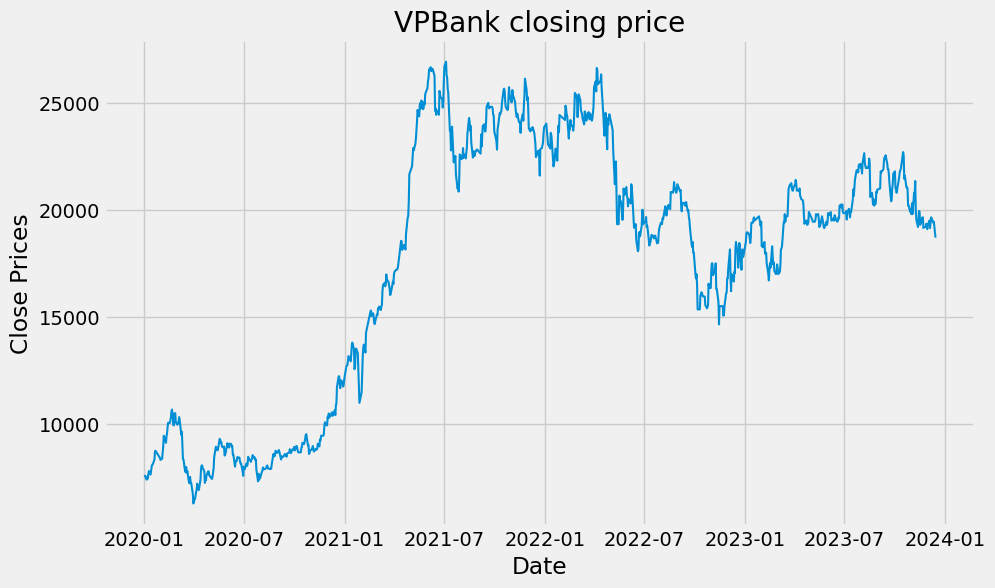

In [6]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_close, linewidth = 1.5)
plt.title('VPBank closing price')
plt.show()

<Axes: ylabel='Density'>

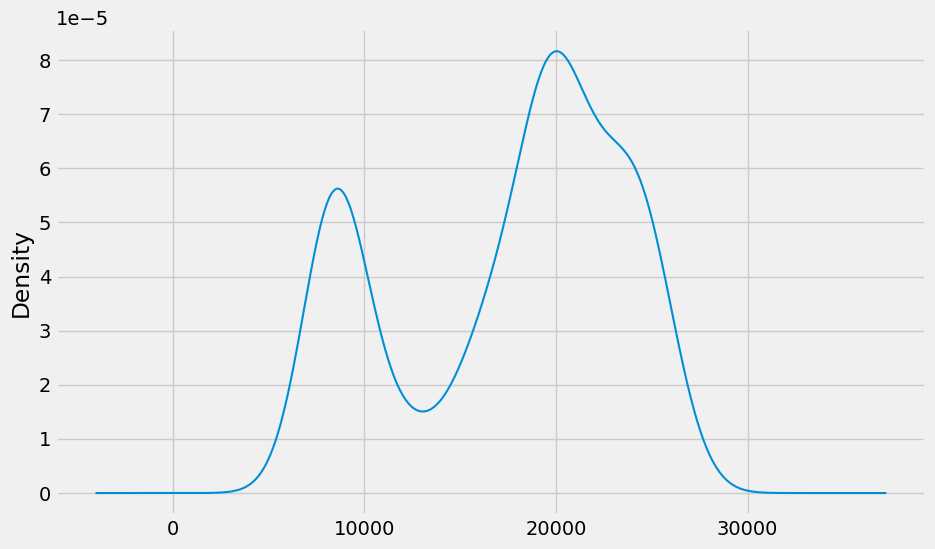

In [7]:
#Distribution of the dataset
df_close.plot(kind='kde', linewidth = 1.5)

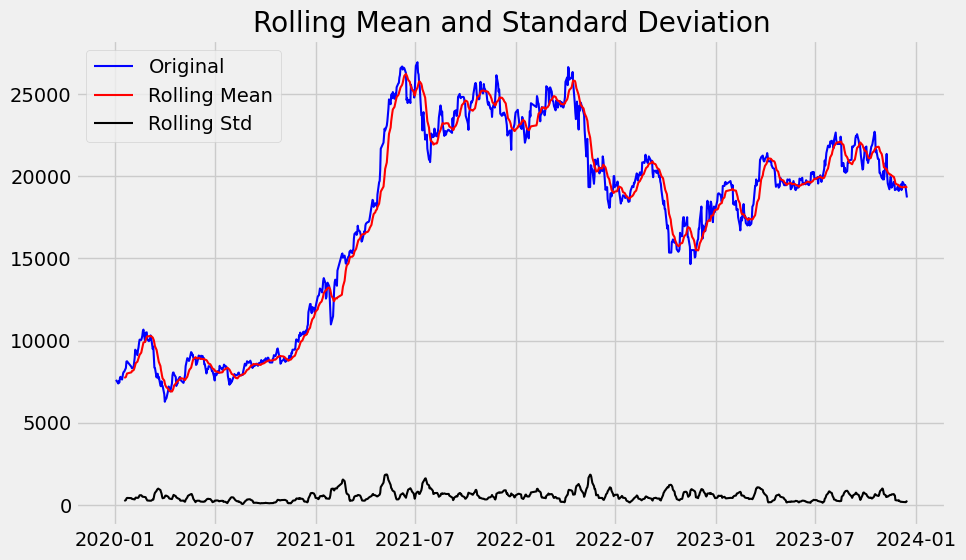

Results of dickey fuller test
Test Statistics                 -1.653980
p-value                          0.454966
No. of lags used                21.000000
Number of observations used    968.000000
critical value (1%)             -3.437123
critical value (5%)             -2.864530
critical value (10%)            -2.568362
dtype: float64


In [8]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original', linewidth = 1.5)
    plt.plot(rolmean, color='red', label='Rolling Mean', linewidth = 1.5)
    plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth = 1.5)
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Test Statistics               -6.024841e+00
p-value                        1.464294e-07
No. of lags used               2.200000e+01
Number of observations used    9.660000e+02
critical value (1%)           -3.437138e+00
critical value (5%)           -2.864537e+00
critical value (10%)          -2.568366e+00
dtype: float64


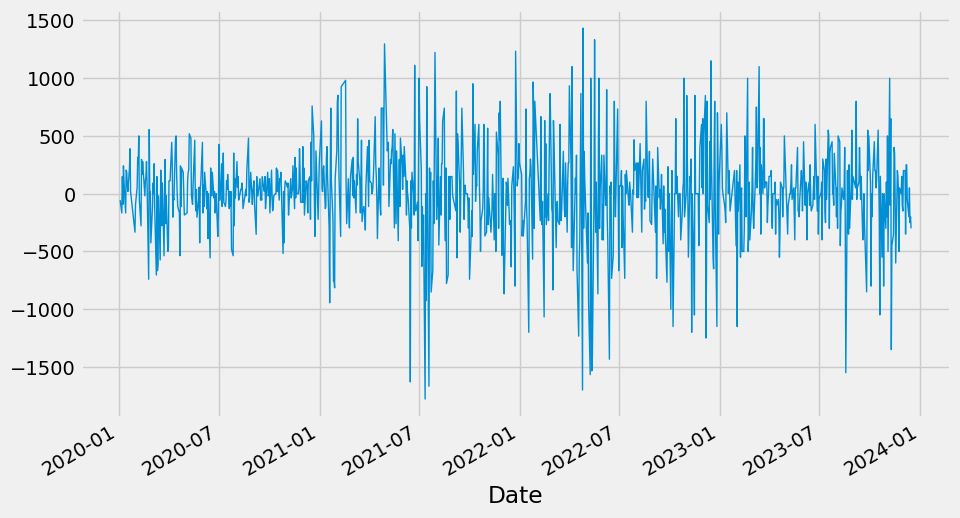

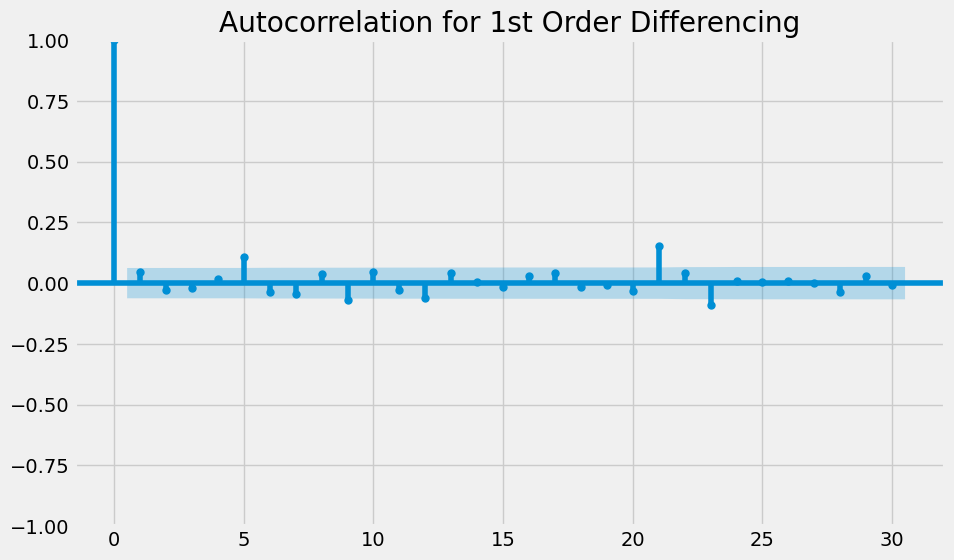

In [9]:
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf
diff1 = diff(df_close, k_diff=1)
diff1.plot(linewidth = 1)
adft = adfuller(diff1,autolag='AIC')
output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
for key,values in adft[4].items():
    output['critical value (%s)'%key] =  values
print(output);
plot2 = plot_acf(diff1.dropna(), title = "Autocorrelation for 1st Order Differencing")


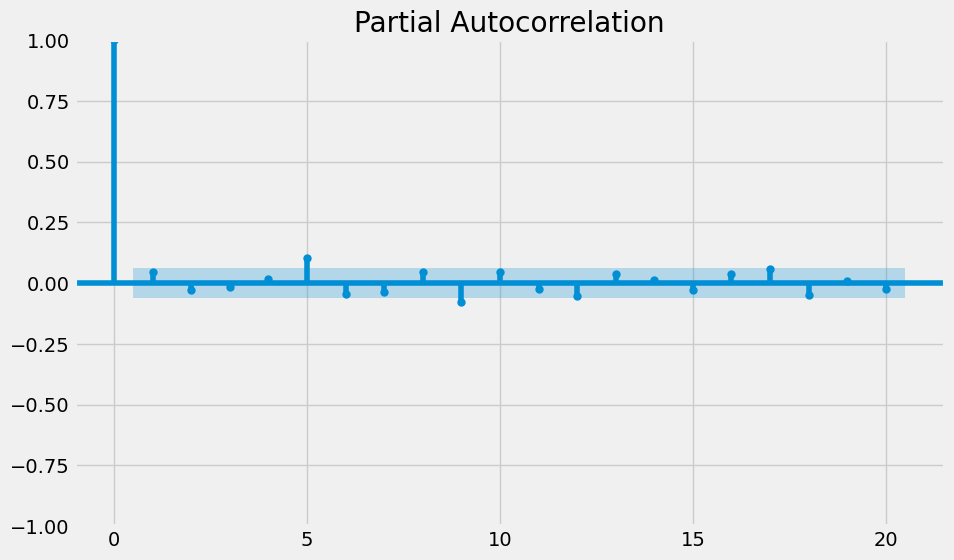

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot = plot_pacf(df_close.diff().dropna(),lags=20)

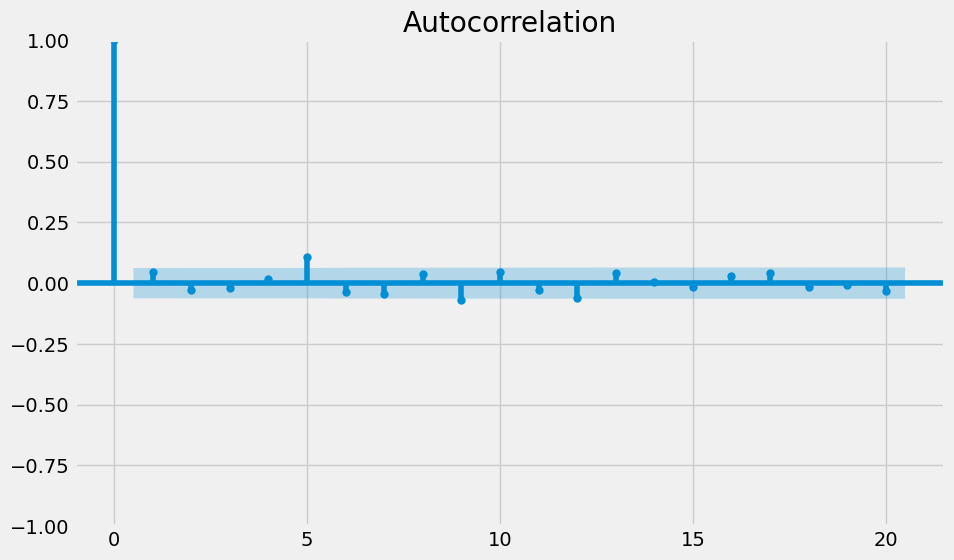

In [11]:
plot2 = plot_acf(df_close.diff().dropna(),lags=20)

In [12]:
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
best_aic = np.inf
best_p, best_q = 0, 0

for p in range(10):
    for q in range(10):
        try:
            model = ARIMA(df_close, order=(p, 1, q))
            fit_model = model.fit()
            aic = fit_model.aic
            print(f'AIC for p={p}, q={q}: {aic}')
            if aic < best_aic:
                best_aic = aic
                best_p, best_q = p, q
        except:
            continue

# In ra giá trị p và q tối ưu
print(f'Best AIC: {best_aic}')
print(f'Best p: {best_p}')
print(f'Best q: {best_q}')

AIC for p=0, q=0: 14682.787066794237
AIC for p=0, q=1: 14682.490415183114
AIC for p=0, q=2: 14683.90105929632
AIC for p=0, q=3: 14685.73006249331
AIC for p=0, q=4: 14687.744634088835
AIC for p=0, q=5: 14677.820671773941
AIC for p=0, q=6: 14678.662192931442
AIC for p=0, q=7: 14679.658508810466
AIC for p=0, q=8: 14679.540420701365
AIC for p=0, q=9: 14675.174935000807
AIC for p=1, q=0: 14682.60699956819
AIC for p=1, q=1: 14683.886483897164
AIC for p=1, q=2: 14685.819238802065
AIC for p=1, q=3: 14687.727676530636
AIC for p=1, q=4: 14688.157872940916
AIC for p=1, q=5: 14679.174708207775
AIC for p=1, q=6: 14679.979208350898
AIC for p=1, q=7: 14675.923957425788
AIC for p=1, q=8: 14675.981775448385
AIC for p=1, q=9: 14674.662491904717
AIC for p=2, q=0: 14683.789600514207
AIC for p=2, q=1: 14685.717346327143
AIC for p=2, q=2: 14684.248331236919
AIC for p=2, q=3: 14672.951124694973
AIC for p=2, q=4: 14664.327495306465
AIC for p=2, q=5: 14665.82007055069
AIC for p=2, q=6: 14664.11690723787
AIC fo

In [13]:
# Assuming train_data is properly defined
model = ARIMA(df_close, order=(best_p, 1, best_q))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  990
Model:                 ARIMA(8, 1, 8)   Log Likelihood               -7313.307
Date:                Tue, 09 Jan 2024   AIC                          14660.615
Time:                        20:38:05   BIC                          14743.858
Sample:                             0   HQIC                         14692.270
                                - 990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9069      0.154     -5.904      0.000      -1.208      -0.606
ar.L2         -0.4821      0.099     -4.859      0.000      -0.677      -0.288
ar.L3          0.1276      0.089      1.440      0.1

In [16]:
start_idx = 0
forecast = fitted.predict(start=start_idx, dynamic=False)
forecast[0] = df_close[0]

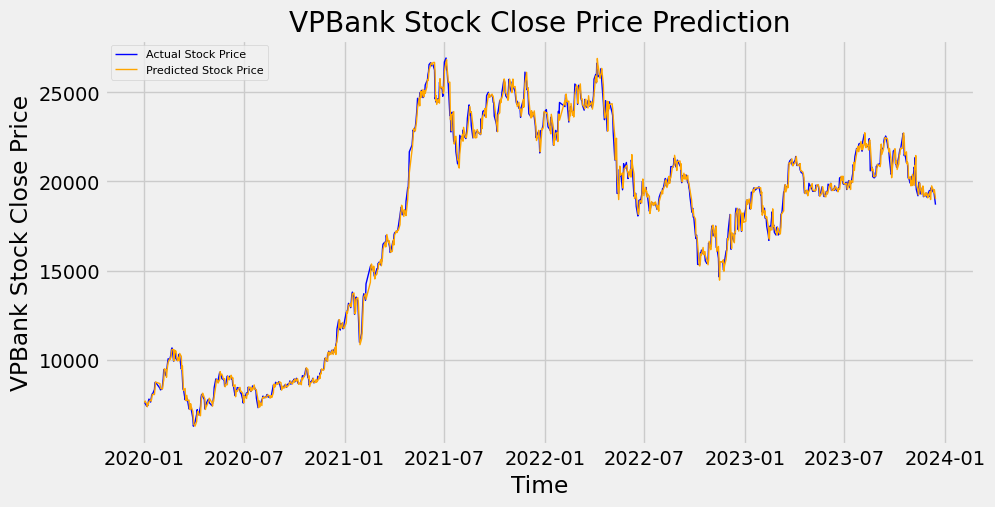

In [17]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_close, color = 'blue', label='Actual Stock Price', linewidth=1)
plt.plot(forecast, color = 'orange',label='Predicted Stock Price', linewidth=1)

plt.title('VPBank Stock Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('VPBank Stock Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
mse = mean_squared_error(df_close, forecast)
print('MSE: '+str(mse))
mae = mean_absolute_error(df_close, forecast)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(df_close, forecast))
print('RMSE: '+str(rmse))
df_close_flat = np.array(df_close).flatten()
forecast_flat = np.array(forecast).flatten()
mape = np.mean(np.abs((df_close_flat - forecast_flat) / df_close_flat)) * 100
print('MAPE: ' + str(mape) + '%')

MSE: 154419.31436904956
MAE: 279.90275189693494
RMSE: 392.9622302067332
MAPE: 1.6800925739112973%


In [123]:
start_idx = 991
end_idx = 1000
forecast = fitted.predict(start=start_idx, end=end_idx, dynamic=False)
forecast

991     18585.912169
992     18653.942583
993     18593.788192
994     18450.137346
995     18428.844866
996     18463.276613
997     18478.102356
998     18480.783700
999     18463.855173
1000    18575.849878
Name: predicted_mean, dtype: float64

In [133]:
jan = pd.date_range(start='16-12-2023', end='25-12-2023')
forecast.index = jan

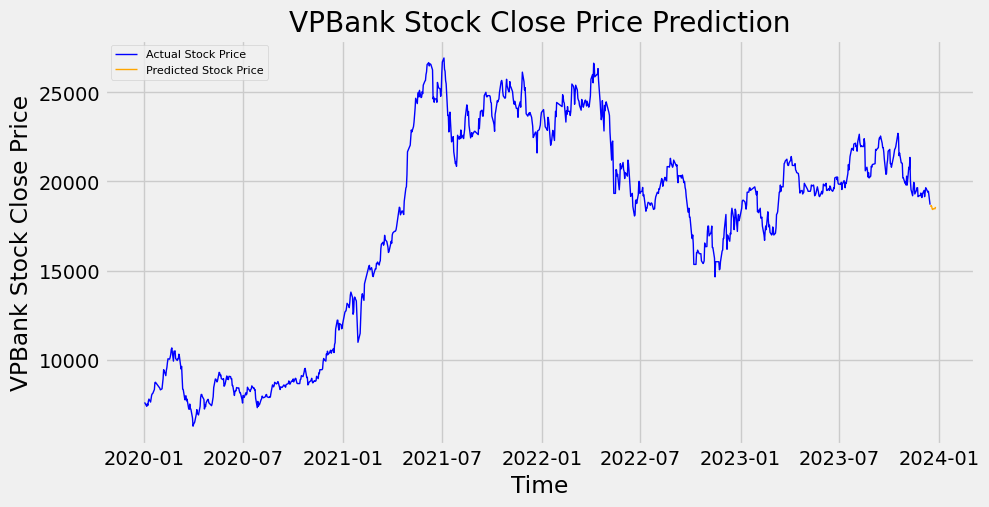

In [134]:

plt.figure(figsize=(10,5), dpi=100)
plt.plot(df_close, color = 'blue', label='Actual Stock Price', linewidth=1)
plt.plot(forecast, color = 'orange',label='Predicted Stock Price', linewidth=1)

plt.title('VPBank Stock Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('VPBank Stock Close Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

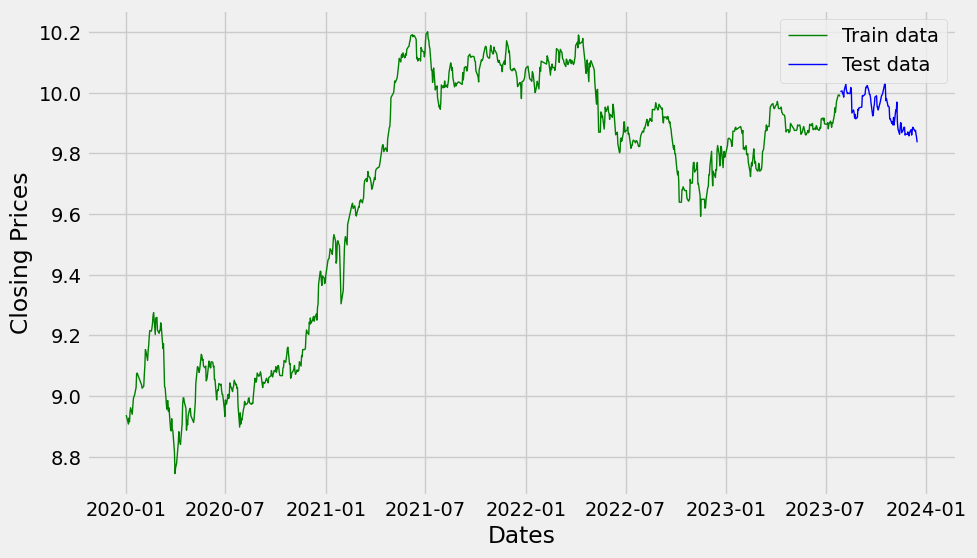

In [19]:
#split data into train and training set
df_log = np.log(df_close)
train_data, test_data = df_log[:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'green', label='Train data', linewidth = 1)
plt.plot(test_data, 'blue', label='Test data', linewidth = 1)
plt.legend()

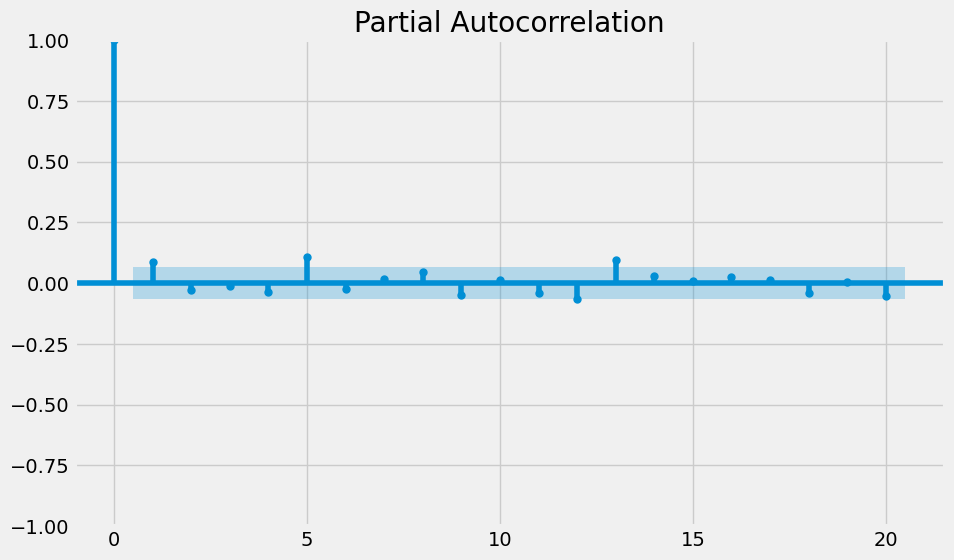

In [20]:
plot = plot_pacf(train_data.diff().dropna(),lags=20)

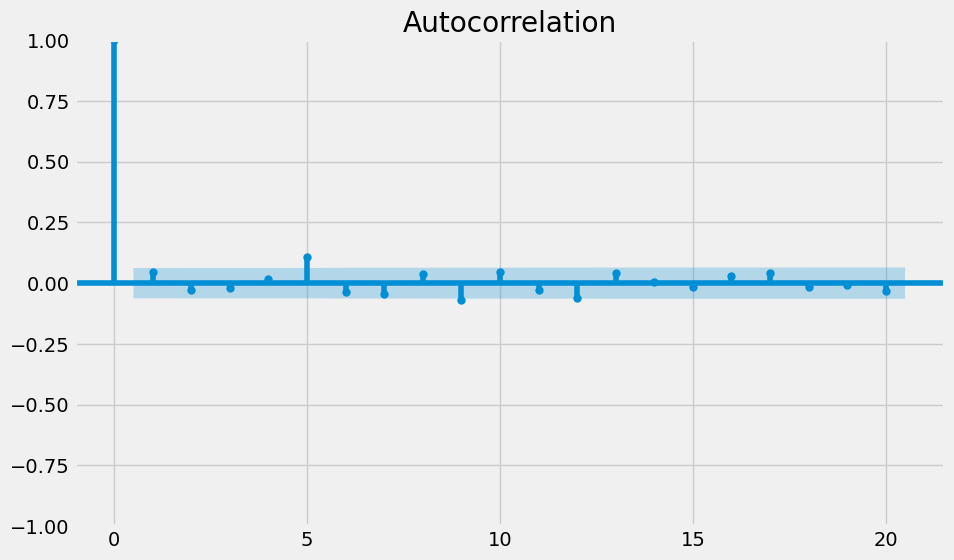

In [21]:
plot = plot_acf(df_close.diff().dropna(),lags=20)

In [22]:
warnings.filterwarnings('ignore')
best_aic = np.inf
best_p, best_q = 0, 0

for p in range(10):
    for q in range(10):
        try:
            model = ARIMA(train_data, order=(p, 1, q))
            fit_model = model.fit()
            aic = fit_model.aic
            print(f'AIC for p={p}, q={q}: {aic}')
            if aic < best_aic:
                best_aic = aic
                best_p, best_q = p, q
        except:
            continue

# In ra giá trị p và q tối ưu
print(f'Best AIC: {best_aic}')
print(f'Best p: {best_p}')
print(f'Best q: {best_q}')

AIC for p=0, q=0: -4091.465547192607
AIC for p=0, q=1: -4096.6225045174415
AIC for p=0, q=2: -4094.8521545503627
AIC for p=0, q=3: -4092.8714613785833
AIC for p=0, q=4: -4093.1595052360954
AIC for p=0, q=5: -4099.71372790251
AIC for p=0, q=6: -4097.756642979171
AIC for p=0, q=7: -4096.004540689284
AIC for p=0, q=8: -4095.098946026339
AIC for p=0, q=9: -4095.890472275666
AIC for p=1, q=0: -4096.338388218043
AIC for p=1, q=1: -4094.8773994941494
AIC for p=1, q=2: -4092.874208096995
AIC for p=1, q=3: -4091.5980551867597
AIC for p=1, q=4: -4094.6296462538694
AIC for p=1, q=5: -4097.376399794195
AIC for p=1, q=6: -4095.9225457580324
AIC for p=1, q=7: -4093.8313076277063
AIC for p=1, q=8: -4093.689048953618
AIC for p=1, q=9: -4094.3365832514082
AIC for p=2, q=0: -4094.8716200297786
AIC for p=2, q=1: -4092.9058690730617
AIC for p=2, q=2: -4090.864063847328
AIC for p=2, q=3: -4093.186381361099
AIC for p=2, q=4: -4100.474220355973
AIC for p=2, q=5: -4095.239124834665
AIC for p=2, q=6: -4099.688

In [23]:
model = ARIMA(train_data, order=(best_p, 1, best_q))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  891
Model:                 ARIMA(4, 1, 5)   Log Likelihood                2068.341
Date:                Tue, 09 Jan 2024   AIC                          -4116.682
Time:                        20:43:11   BIC                          -4068.770
Sample:                             0   HQIC                         -4098.370
                                - 891                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0174      0.069      0.251      0.802      -0.118       0.153
ar.L2         -0.0166      0.070     -0.238      0.812      -0.154       0.120
ar.L3          0.1183      0.067      1.774      0.0

In [24]:
forecast_results = fitted.get_forecast(steps=len(test_data), alpha=0.05)
forecast_values = forecast_results.predicted_mean
stderr = forecast_results.se_mean
conf_int = forecast_results.conf_int(alpha=0.05)

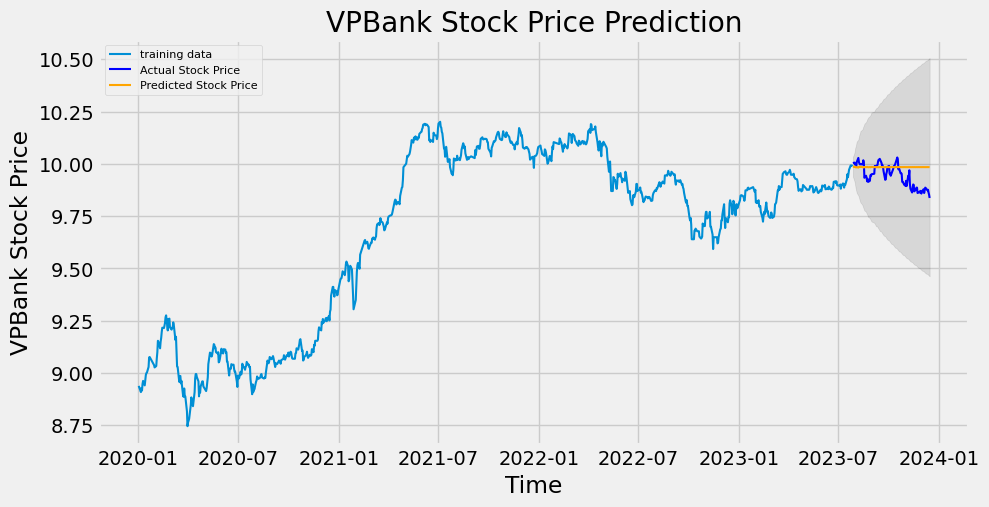

In [25]:
fc = pd.DataFrame(forecast_values)
fc = fc.set_index(test_data.index)
lower = pd.DataFrame(conf_int.iloc[:,0])
lower = lower.set_index(test_data.index)
upper = pd.DataFrame(conf_int.iloc[:,1])
upper = upper.set_index(test_data.index)

# Plot

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data', linewidth = 1.5)
plt.plot(test_data, color = 'blue', label='Actual Stock Price', linewidth = 1.5)
plt.plot(fc, color = 'orange',label='Predicted Stock Price', linewidth = 1.5)
plt.fill_between(lower.index, lower["lower Close"], upper["upper Close"], 
                 color='k', alpha=.10)
plt.title('VPBank Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VPBank Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [26]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
test_data_flat = np.array(test_data).flatten()
fc_flat = np.array(fc).flatten()
mape = np.mean(np.abs((test_data_flat - fc_flat) / test_data_flat)) * 100
print('MAPE: ' + str(mape) + '%')

MSE: 0.004552267275259377
MAE: 0.053493777703065244
RMSE: 0.06747049188541149
MAPE: 0.5400503915531673%


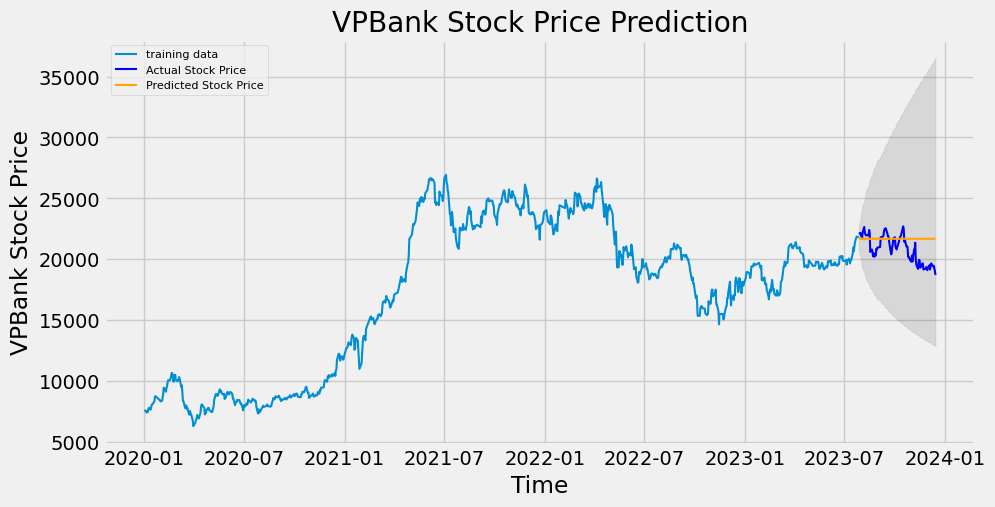

In [27]:
fc = np.exp(fc)
lower = np.exp(lower)
upper = np.exp(upper)
pre_train_data = df_close[:int(len(df_close)*0.9)]
pre_test_data = df_close[int(len(df_close)*0.9):]
# Plot

plt.figure(figsize=(10,5), dpi=100)
plt.plot(pre_train_data, label='training data', linewidth = 1.5)
plt.plot(pre_test_data, color = 'blue', label='Actual Stock Price', linewidth = 1.5)
plt.plot(fc, color = 'orange',label='Predicted Stock Price', linewidth = 1.5)
plt.fill_between(lower.index, lower["lower Close"], upper["upper Close"], 
                 color='k', alpha=.10)
plt.title('VPBank Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VPBank Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [28]:
mse = mean_squared_error(pre_test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(pre_test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(pre_test_data, fc))
print('RMSE: '+str(rmse))
pre_test_data_flat = np.array(pre_test_data).flatten()
fc_flat = np.array(fc).flatten()
mape = np.mean(np.abs((pre_test_data_flat - fc_flat) / pre_test_data_flat)) * 100
print('MAPE: ' + str(mape) + '%')

MSE: 1941250.4589983206
MAE: 1115.7300348087085
RMSE: 1393.2876440270045
MAPE: 5.56703502807259%


In [29]:
model_predictions = []
for i in range(len(test_data)):
    model = ARIMA(train_data, order=(best_p, 1, best_q))
    model_fit = model.fit()
    output = model_fit.forecast()
    model_predictions.append(output)

    actual_test_value = test_data[i]
    
    train_data = pd.concat([train_data, pd.Series([actual_test_value])], ignore_index=True)

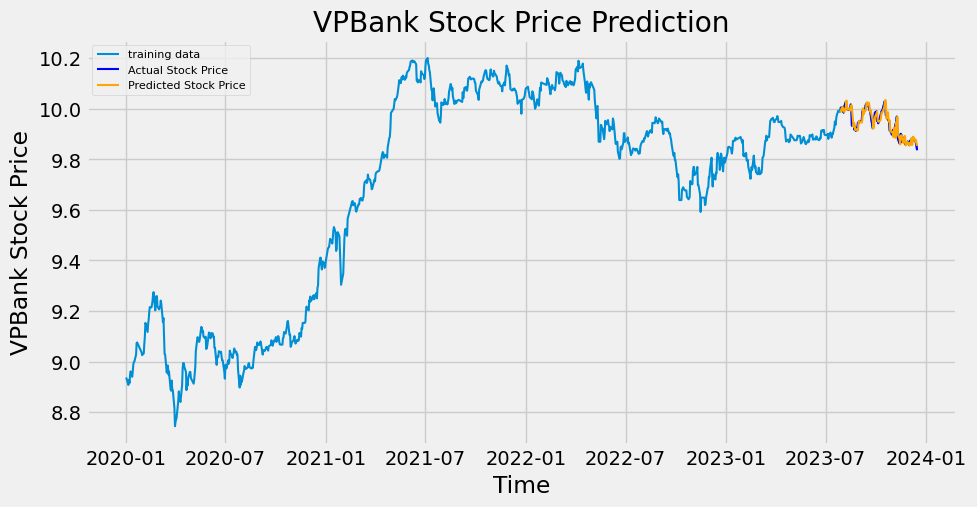

In [30]:
# Plot
train_data.index = df_close.index
date_range = test_data.index
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data', linewidth = 1.5)
plt.plot(test_data, color = 'blue', label='Actual Stock Price', linewidth = 1.5)
plt.plot(date_range, model_predictions, color = 'orange',label='Predicted Stock Price', linewidth = 1.5)

plt.title('VPBank Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VPBank Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [31]:
mse = mean_squared_error(test_data, model_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, model_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, model_predictions))
print('RMSE: '+str(rmse))
test_data_flat = np.array(test_data).flatten()
model_predictions_flat = np.array(model_predictions).flatten()
mape = np.mean(np.abs((test_data_flat - model_predictions_flat) / test_data_flat)) * 100
print('MAPE: ' + str(mape) + '%')

MSE: 0.0003963929050766915
MAE: 0.014872090804026952
RMSE: 0.01990961840610441
MAPE: 0.14961371254977388%


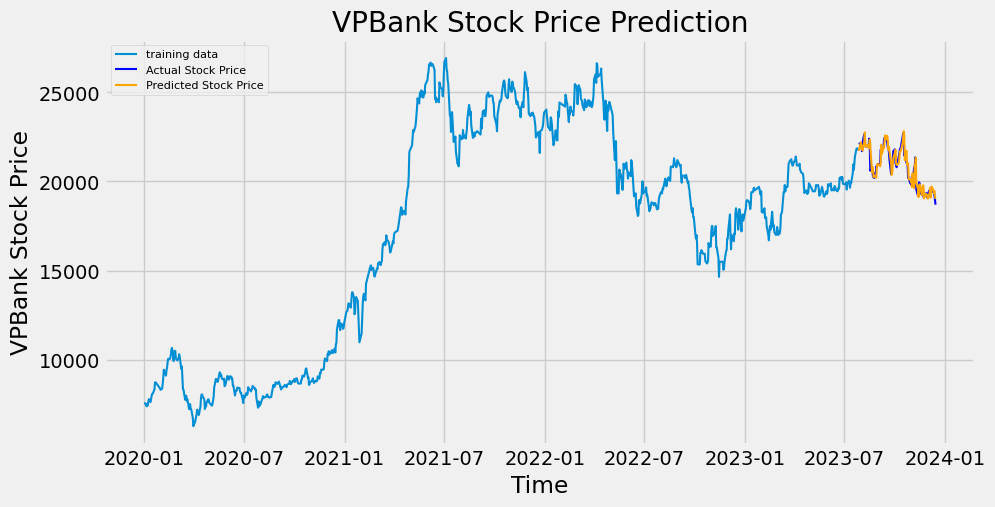

In [32]:
model_predictions = np.exp(model_predictions)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(pre_train_data, label='training data', linewidth = 1.5)
plt.plot(pre_test_data, color = 'blue', label='Actual Stock Price', linewidth = 1.5)
plt.plot(date_range, model_predictions, color = 'orange',label='Predicted Stock Price', linewidth = 1.5)

plt.title('VPBank Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('VPBank Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
mse = mean_squared_error(pre_test_data, model_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(pre_test_data, model_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(pre_test_data, model_predictions))
print('RMSE: '+str(rmse))
model_predictions_flat = np.array(model_predictions).flatten()
mape = np.mean(np.abs((pre_test_data_flat - model_predictions_flat) / pre_test_data_flat)) * 100
print('MAPE: ' + str(mape) + '%')

MSE: 173092.61791244653
MAE: 310.20485612088504
RMSE: 416.0440095860611
MAPE: 1.492898694908379%


In [38]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
data_array = df_close.values.reshape(-1, 1)
# Chuẩn bị dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_array)

# Chia dữ liệu thành tập huấn luyện và tập kiểm thử
train_size = int(len(data_scaled) * 0.9)
train_data, test_data = data_scaled[:train_size], data_scaled[train_size:]

# Hàm tạo dữ liệu đầu vào cho mô hình
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps)]
        X.append(a)
        Y.append(dataset[i + time_steps])
    return np.array(X), np.array(Y)

# Thiết lập tham số
time_steps = 60  # Số lượng bước thời gian để xem xét cho việc dự đoán
X_train, Y_train = create_dataset(train_data, time_steps)
X_test, Y_test = create_dataset(test_data, time_steps)

# Reshape dữ liệu để phù hợp với đầu vào của mô hình LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Thêm lớp Dropout
model.add(LSTM(units=100, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_test, Y_test))


# Dự đoán giá cổ phiếu trên tập kiểm thử
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(np.reshape(predicted_stock_price, (predicted_stock_price.shape[0], 1)))
test_data = scaler.inverse_transform(np.reshape(test_data, (test_data.shape[0], 1)))

Epoch 1/20
13/13 [==============================] - 9s 231ms/step - loss: 0.0842 - val_loss: 0.0124
Epoch 2/20
13/13 [==============================] - 1s 113ms/step - loss: 0.0100 - val_loss: 0.0013
Epoch 3/20
13/13 [==============================] - 1s 111ms/step - loss: 0.0042 - val_loss: 0.0057
Epoch 4/20
13/13 [==============================] - 1s 114ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 5/20
13/13 [==============================] - 2s 116ms/step - loss: 0.0025 - val_loss: 7.4293e-04
Epoch 6/20
13/13 [==============================] - 1s 112ms/step - loss: 0.0024 - val_loss: 8.3881e-04
Epoch 7/20
13/13 [==============================] - 2s 116ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 8/20
13/13 [==============================] - 1s 114ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 9/20
13/13 [==============================] - 1s 113ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 10/20
13/13 [==============================] - 1s 115ms/step - loss: 0.0022 - val_loss

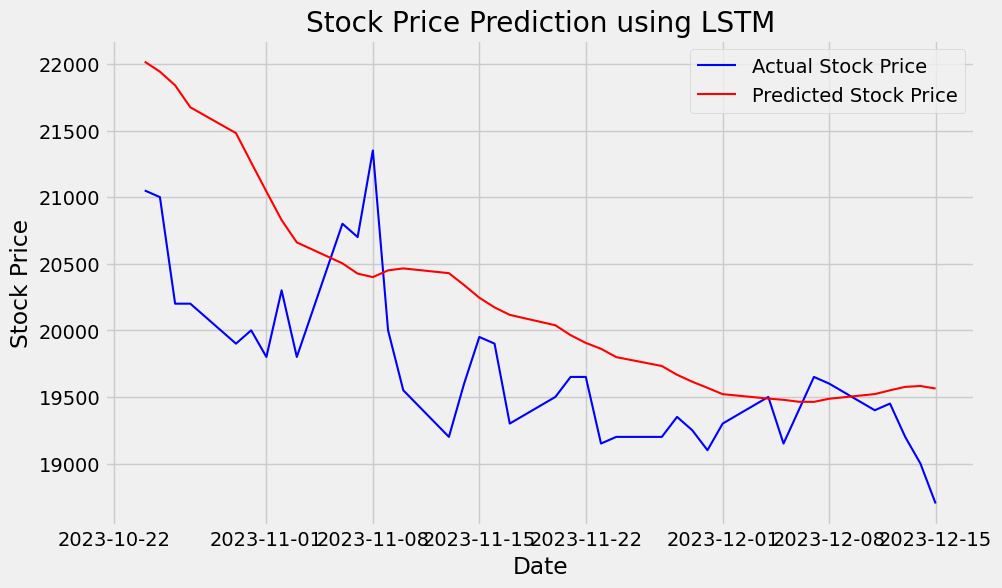

In [39]:
# Vẽ biểu đồ so sánh giá cổ phiếu thực tế và dự đoán
plt.figure(figsize=(10, 6))
plt.plot(df_close.index[train_size + time_steps:], test_data[time_steps:], label='Actual Stock Price', color='blue', linewidth = 1.5)
plt.plot(df_close.index[train_size + time_steps:], predicted_stock_price, label='Predicted Stock Price', color='red', linewidth = 1.5)
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [40]:
mse = mean_squared_error(predicted_stock_price, test_data[time_steps:])
print('MSE: '+str(mse))
mae = mean_absolute_error(predicted_stock_price, test_data[time_steps:])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(predicted_stock_price, test_data[time_steps:]))
print('RMSE: '+str(rmse))
test_data_flat = np.array(test_data[time_steps:]).flatten()
predicted_stock_price_flat = np.array(predicted_stock_price).flatten()
mape = np.mean(np.abs((test_data_flat - predicted_stock_price_flat) / test_data_flat)) * 100
print('MAPE: ' + str(mape) + '%')

MSE: 559685.2253196912
MAE: 610.1368189102565
RMSE: 748.1211301117562
MAPE: 3.079990825846796%
